In [1]:
import tensorflow as tf
import random
import os
import glob
import cv2
import numpy as np
import torch
import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from tensorflow.keras import models
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.models import save_model
from sklearn.model_selection import train_test_split
import h5py
import shutil
from lime import lime_image
from keras import callbacks

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
current_dir = os.getcwd()
data_folder = os.path.join(current_dir,"Data")

In [4]:
real_paths = glob.glob(os.path.join(data_folder,"Real","*mp4"))
fake_paths = glob.glob(os.path.join(data_folder,"Fake","*mp4"))

In [4]:
image_size=(256,256)
channels = 3

def video_frames(path,size,n_frames=10):
    
    
    filename = os.path.basename(path).split(".")[0]
    folder = path.replace(os.path.basename(path),"")
    
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    
    for i in range(n_frames):
        
        
        
        randomFrameNumber=random.randint(0, frame_count)
        frames.append(randomFrameNumber)
    
    
    #print(frames)
    
    for frame_num in frames:
        
        capture.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        ret, frame = capture.read()
        
        if not ret:
            break
            
            
        
        frame = cv2.resize(frame,size)
        frame = cv2.imwrite(folder + filename + "_" + str(frame_num) + ".jpg",frame)
        
    
    
    
    

In [18]:
real_images = [video_frames(path,image_size) for path in real_paths]
fake_images = [video_frames(path,image_size) for path in fake_paths]

In [44]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [60]:
def face_cropper(dir,size):
    
    for image in dir:
        
        filename = os.path.basename(image).split(".")[0]
        folder = image.replace(os.path.basename(image),"")
        
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 4)
        
        if len(faces) > 0:
            
            for i,(x,y,w,h) in enumerate(faces):
                
                
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 256, 256), 2)
                face = img[y:y + h, x:x + w]
                face = cv2.resize(face,size)
                cv2.imwrite(folder + filename + "_" + f'face{i}.jpg', face)
        
        os.remove(image)



In [6]:
real_images = glob.glob(os.path.join(data_folder,"Real","*jpg"))
fake_images = glob.glob(os.path.join(data_folder,"Fake","*jpg"))

In [7]:
for i in range(len(fake_images) - len(real_images)):
    
    os.remove(fake_images[i])

In [70]:
face_cropper(real_images,image_size)
face_cropper(fake_images,image_size)

In [16]:
train_folder = os.path.join(os.path.join(current_dir,"Dataset"),"Train")
validation_folder = os.path.join(os.path.join(current_dir,"Dataset"),"Validation")

In [39]:
dataGenerator = ImageDataGenerator(horizontal_flip=True,validation_split=0.2)
train_generator = dataGenerator.flow_from_directory(
    train_folder,target_size=(256,256),batch_size=16,class_mode="binary")
validation_generator = dataGenerator.flow_from_directory(
    validation_folder,target_size=(256,256),batch_size=16,class_mode="binary")

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [40]:
mobile_net = keras.applications.mobilenet.MobileNet(
    
    include_top = True,
    weights = None,
    classes=2,
    input_shape = (256,256,3),
    classifier_activation="sigmoid"
    
)


In [41]:
mobile_net.compile(optimizer ="adam", loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [42]:
mobile_net.summary()

Model: "mobilenet_1.00_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                         

In [43]:
model = models.Sequential([
    
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    
])
model.add(mobile_net)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 mobilenet_1.00_256 (Functio  (None, 2)                3230914   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [45]:
model.compile(optimizer ="adam", loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [46]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True,
                                       verbose=1)
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=current_dir, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None)

lr_adjust=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=0, mode="auto",
    min_delta=0.00001,  cooldown=0,  min_lr=0) 

In [47]:
EPOCHS = 100
history = model.fit(train_generator, epochs = EPOCHS, validation_data = validation_generator,callbacks =[earlystopping,lr_adjust,checkpoint])

Epoch 1/100


8751/8751 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8037WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1465s 167ms/step - loss: 0.4362 - accuracy: 0.8037 - val_loss: 0.2955 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 2/100
8751/8751 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9351WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1446s 165ms/step - loss: 0.1805 - accuracy: 0.9351 - val_loss: 0.2020 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 3/100
8751/8751 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9565WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1502s 172ms/step - loss: 0.1186 - accuracy: 0.9565 - val_loss: 0.1805 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 4/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9655WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1658s 189ms/step - loss: 0.0925 - accuracy: 0.9655 - val_loss: 0.1334 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 5/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9706WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1439s 164ms/step - loss: 0.0783 - accuracy: 0.9706 - val_loss: 0.1280 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 6/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9740WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1343s 153ms/step - loss: 0.0688 - accuracy: 0.9740 - val_loss: 0.0975 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 7/100
8751/8751 [==============================] - 1333s 152ms/step - loss: 0.0629 - accuracy: 0.9766 - val_loss: 0.1162 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 8/100
8751/8751 [==============================] - 1334s 152ms/step - loss: 0.0480 - accuracy: 0.9816 - val_loss: 0.1069 - val_accuracy: 0.9607 - lr: 5.0000e-04
Epoch 9/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9850WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1346s 154ms/step - loss: 0.0402 - accuracy: 0.9850 - val_loss: 0.0779 - val_accuracy: 0.9715 - lr: 2.5000e-04
Epoch 10/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9856WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1346s 154ms/step - loss: 0.0379 - accuracy: 0.9856 - val_loss: 0.0717 - val_accuracy: 0.9736 - lr: 2.5000e-04
Epoch 11/100
8751/8751 [==============================] - 1339s 153ms/step - loss: 0.0366 - accuracy: 0.9860 - val_loss: 0.0723 - val_accuracy: 0.9749 - lr: 2.5000e-04
Epoch 12/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9874WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1409s 161ms/step - loss: 0.0336 - accuracy: 0.9874 - val_loss: 0.0693 - val_accuracy: 0.9754 - lr: 1.2500e-04
Epoch 13/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9882WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1496s 171ms/step - loss: 0.0311 - accuracy: 0.9882 - val_loss: 0.0676 - val_accuracy: 0.9760 - lr: 1.2500e-04
Epoch 14/100
8751/8751 [==============================] - 1381s 158ms/step - loss: 0.0303 - accuracy: 0.9883 - val_loss: 0.0688 - val_accuracy: 0.9770 - lr: 1.2500e-04
Epoch 15/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9894WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1395s 159ms/step - loss: 0.0281 - accuracy: 0.9894 - val_loss: 0.0660 - val_accuracy: 0.9772 - lr: 6.2500e-05
Epoch 16/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9896WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1396s 160ms/step - loss: 0.0280 - accuracy: 0.9896 - val_loss: 0.0633 - val_accuracy: 0.9781 - lr: 6.2500e-05
Epoch 17/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9899WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1398s 160ms/step - loss: 0.0268 - accuracy: 0.9899 - val_loss: 0.0617 - val_accuracy: 0.9788 - lr: 6.2500e-05
Epoch 18/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9902WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1399s 160ms/step - loss: 0.0261 - accuracy: 0.9902 - val_loss: 0.0615 - val_accuracy: 0.9793 - lr: 6.2500e-05
Epoch 19/100
8751/8751 [==============================] - 1387s 159ms/step - loss: 0.0261 - accuracy: 0.9902 - val_loss: 0.0620 - val_accuracy: 0.9791 - lr: 6.2500e-05
Epoch 20/100
8751/8751 [==============================] - 1387s 159ms/step - loss: 0.0245 - accuracy: 0.9908 - val_loss: 0.0623 - val_accuracy: 0.9786 - lr: 3.1250e-05
Epoch 21/100
8751/8751 [==============================] - 1390s 159ms/step - loss: 0.0247 - accuracy: 0.9905 - val_loss: 0.0617 - val_accuracy: 0.9797 - lr: 1.5625e-05
Epoch 22/100
8751/8751 [==============================] - 1388s 159ms/step - loss: 0.0234 - accuracy: 0.9912 - val_loss: 0.0616 - val_accuracy: 0.9787 - lr: 7.8125e-06
Epoch 23/100
8751/8751 [==============================] - 3140s 359ms/step - loss: 0.0244 - accuracy: 0.9910 - val_loss: 0.0617 - val_accuracy: 0.9797 - lr: 3.9063e-06
Epoch

In [73]:
test_dir = os.path.join(os.path.join(current_dir,"Dataset"),"Test")
generator_test = dataGenerator.flow_from_directory(test_dir,target_size=(256,256),batch_size=1,class_mode="binary")

Found 10905 images belonging to 2 classes.


In [74]:
generator_test.class_indices

{'Fake': 0, 'Real': 1}

In [75]:
X, y = generator_test.next()

In [76]:
model.predict(X)[0][0]

1/1 [==============================] - 0s 22ms/step


0.00082823186

In [78]:
int(y[0])

0

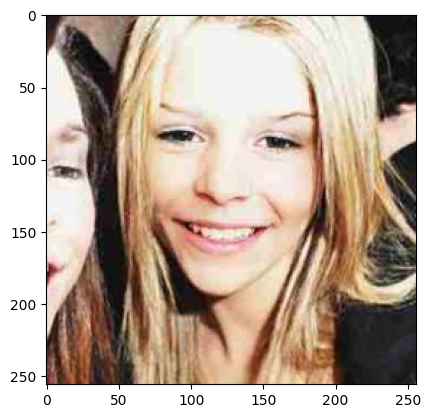

In [77]:
plt.imshow(np.squeeze(X).astype("uint8"))

In [65]:
len(generator_test)

10905

In [79]:
true_Positive = []
true_Positive_pred = []

true_Negative = []
true_Negative_pred = []

false_Positive = []
false_Positive_pred = []

false_Negative = []
false_Negative_pred = []

for i in range(len(generator_test)):
    
    X,y = generator_test.next()
    pred = model.predict(X,verbose=0)[0][0]
    
    if round(pred) == y[0] and y[0] == 1:
        true_Positive.append(X)
        true_Positive_pred.append(pred)
        
    elif round(pred) == y[0] and y[0] == 0:
        true_Negative.append(X)
        true_Negative_pred.append(pred)
        
    elif y[0] == 0:
        false_Negative.append(X)
        false_Negative_pred.append(pred)
        
    else:
        false_Positive.append(X)
        false_Positive_pred.append(pred)
        

In [86]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(1, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j].astype("uint8")))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return


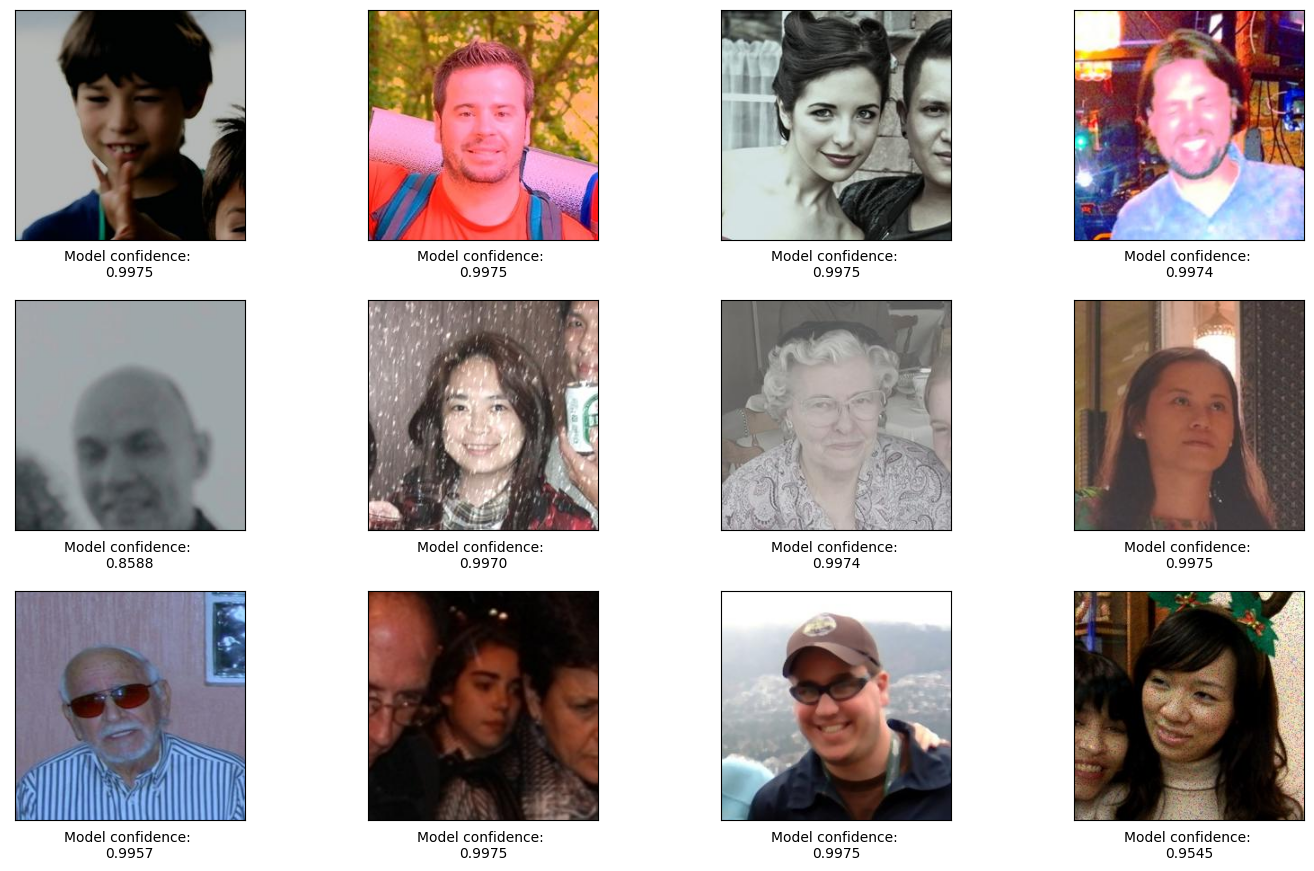

In [87]:
plotter(true_Positive,true_Positive_pred)

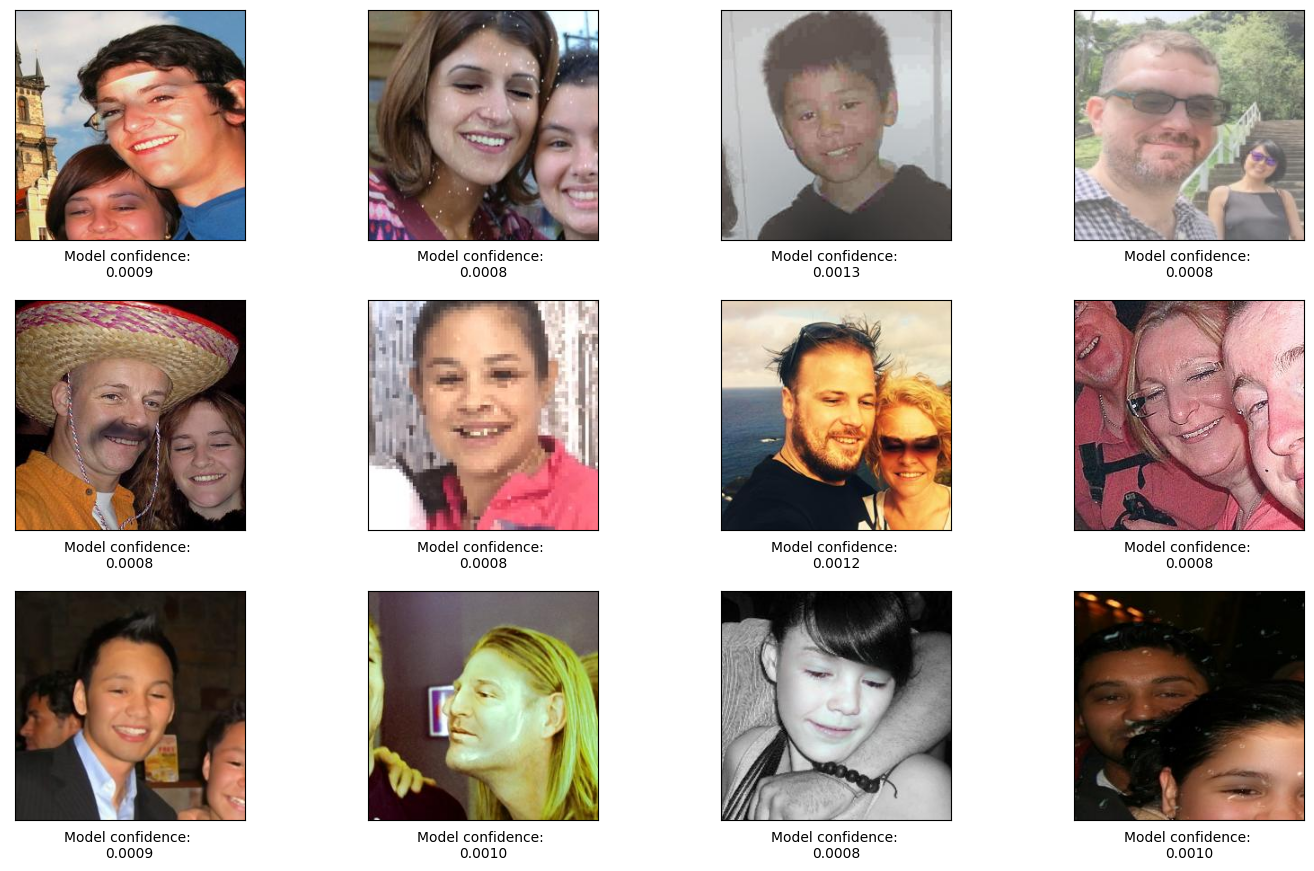

In [88]:
plotter(true_Negative,true_Negative_pred)

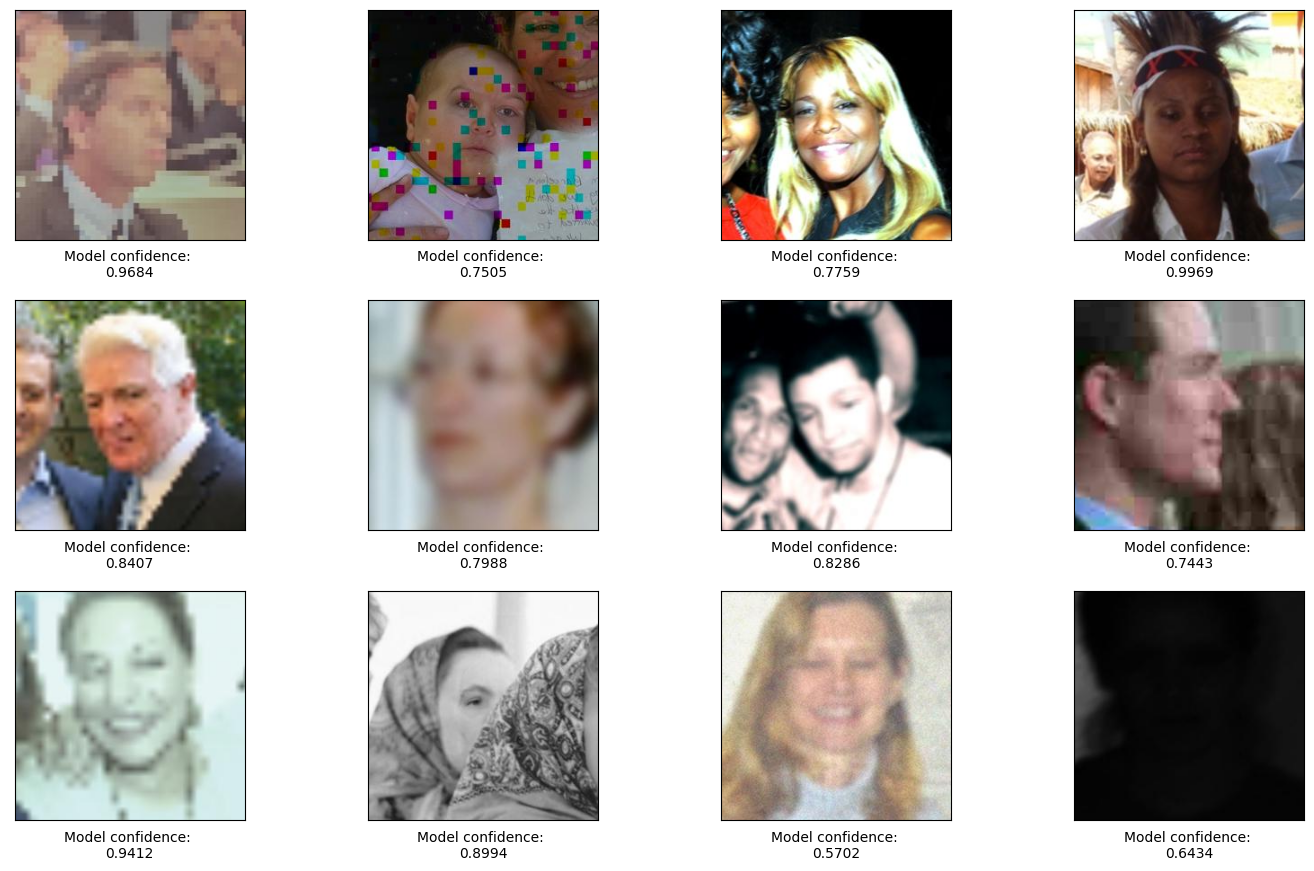

In [89]:
plotter(false_Negative,false_Negative_pred)

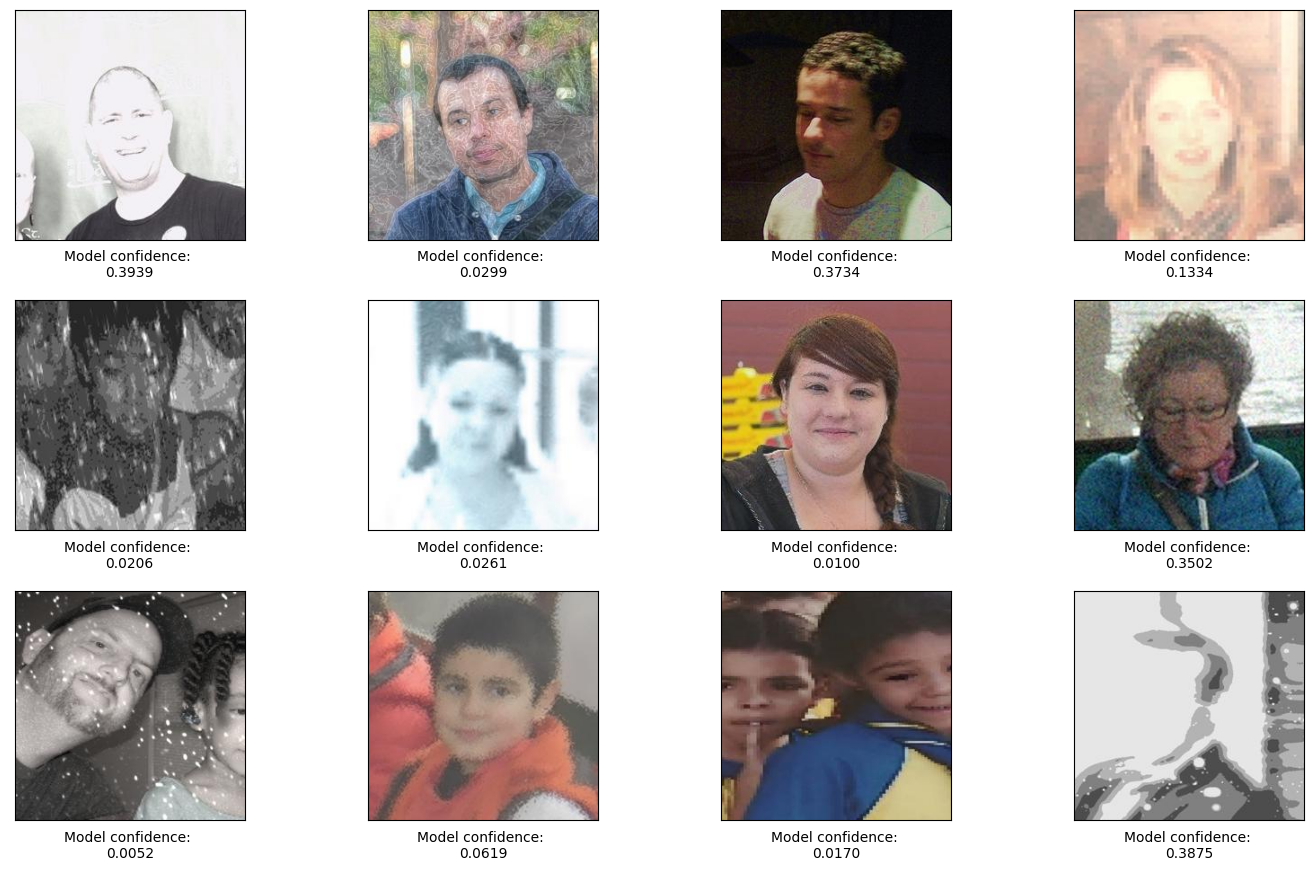

In [90]:
plotter(false_Positive,false_Positive_pred)

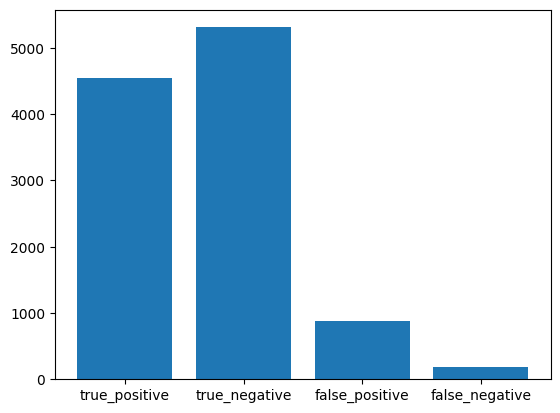

In [93]:
fig, ax = plt.subplots()

len_arr = [len(true_Positive),len(true_Negative),len(false_Positive),len(false_Negative)]
labels_arr = ["true_positive","true_negative","false_positive","false_negative"]

ax.bar(labels_arr, len_arr)
plt.show()

In [94]:
model.evaluate(generator_test)

10905/10905 [==============================] - 124s 11ms/step - loss: 0.3560 - accuracy: 0.9022


[0.3559878170490265, 0.9022466540336609]

In [ ]:
from sklearn.metrics import confusion_matrix